# Preperation

In [35]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

In [36]:
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/Final_Assignment/main/auto-mpg.csv")

# Data includes "?" values on horsepower, should be excluded, also only 70s sales
data = data.loc[(data["model year"] < 80) &
                (data["horsepower"] != "?")]
data = data.astype({"horsepower":"int"})

# Make log mpg
data["lnmpg"] = np.log(data["mpg"])

# Make origin names from origin for an easier understanding
def OriginName(origin):
    if origin == 1:
        return "USA"
    elif origin == 2:
        return "Europe"
    else:
        return "Japan"
    
data["OriginName"] = data["origin"].apply(OriginName)
data["IsEU"] = (data["origin"] == 2).astype(int)
data["IsJP"] = (data["origin"] == 3).astype(int)
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,lnmpg,OriginName,IsEU,IsJP
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,2.890372,USA,0,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,2.708050,USA,0,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,2.890372,USA,0,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,2.772589,USA,0,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,2.833213,USA,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,37.3,4,91.0,69,2130,14.7,79,2,fiat strada custom,3.618993,Europe,1,0
305,28.4,4,151.0,90,2670,16.0,79,1,buick skylark limited,3.346389,USA,0,0
306,28.8,6,173.0,115,2595,11.3,79,1,chevrolet citation,3.360375,USA,0,0
307,26.8,6,173.0,115,2700,12.9,79,1,oldsmobile omega brougham,3.288402,USA,0,0


## Variables:
- mpg: The fuel economy of the car in terms of miles travelled per gallon of gasoline
- cylinders: The number of cylinders in the car's engine
- displacement: The volume of air displaced by all the pistons of a piston engine
- horsepower: Horsepower is a measure of power the engine produces
- weight: The total weight of the car
- acceleration: The time in seconds it takes for the car to reach 60 miles per hour
- model year: The year (in the 20th century) the car model was released. For example 75 means the car was released in 1975.
- origin: The region where the car was manufactured. 1 - USA. 2 - Europe. 3 - Japan
- car name: The name of the car model.

# Part 1

In [37]:
data["mpg"].describe().round(3)

count    307.000
mean      21.084
std        6.482
min        9.000
25%       16.000
50%       20.000
75%       26.000
max       43.100
Name: mpg, dtype: float64

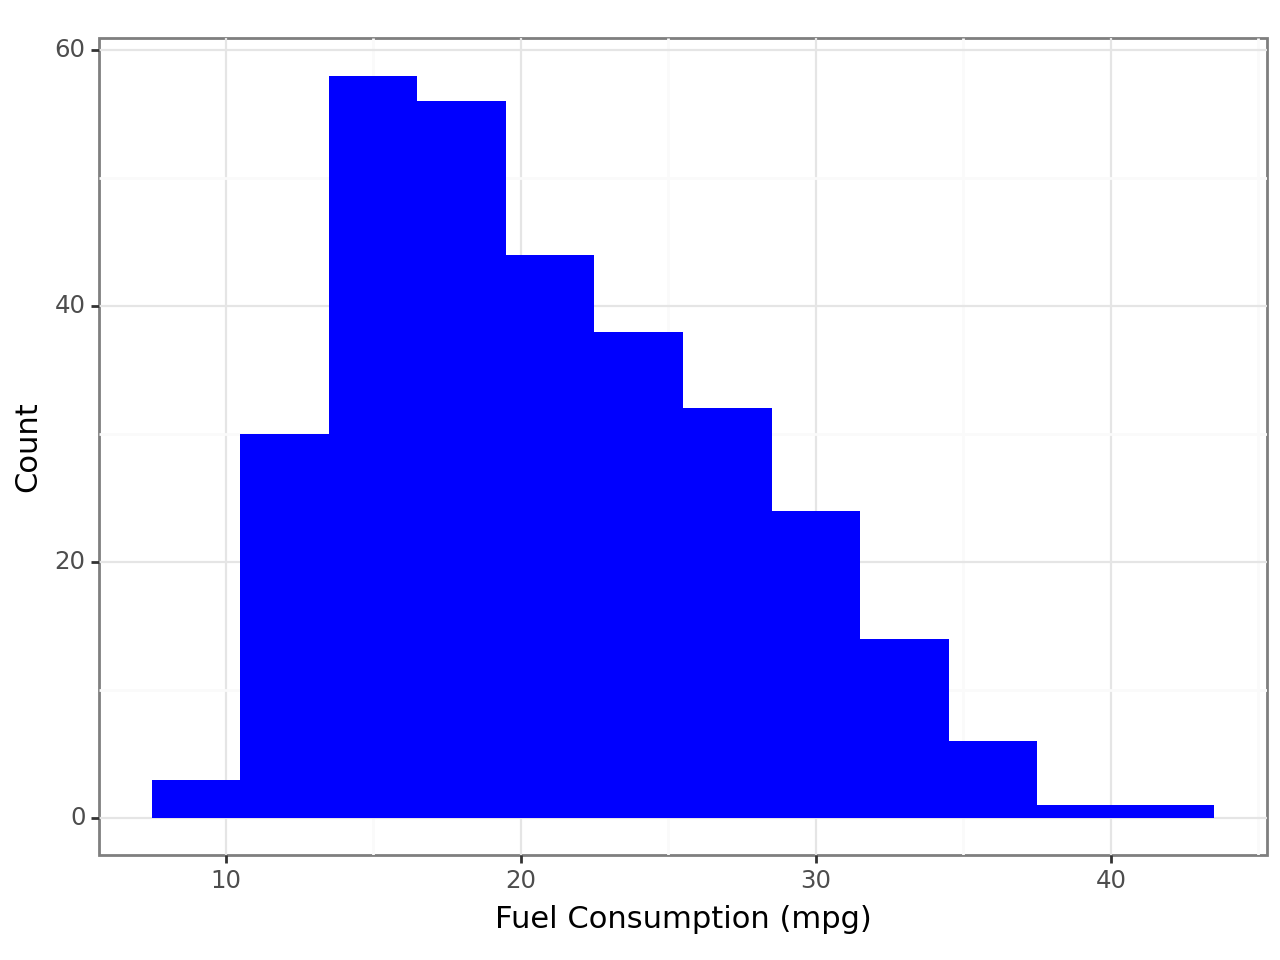

<Figure Size: (640 x 480)>

In [38]:
# Look at the distribution of mpg
(
    ggplot(data, aes(x = "mpg")) +
    geom_histogram(binwidth = 3,
                   fill = "blue") +
    labs(x = "Fuel Consumption (mpg)", y = "Count") +
    theme_bw()
)

c:\Users\Szabados\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


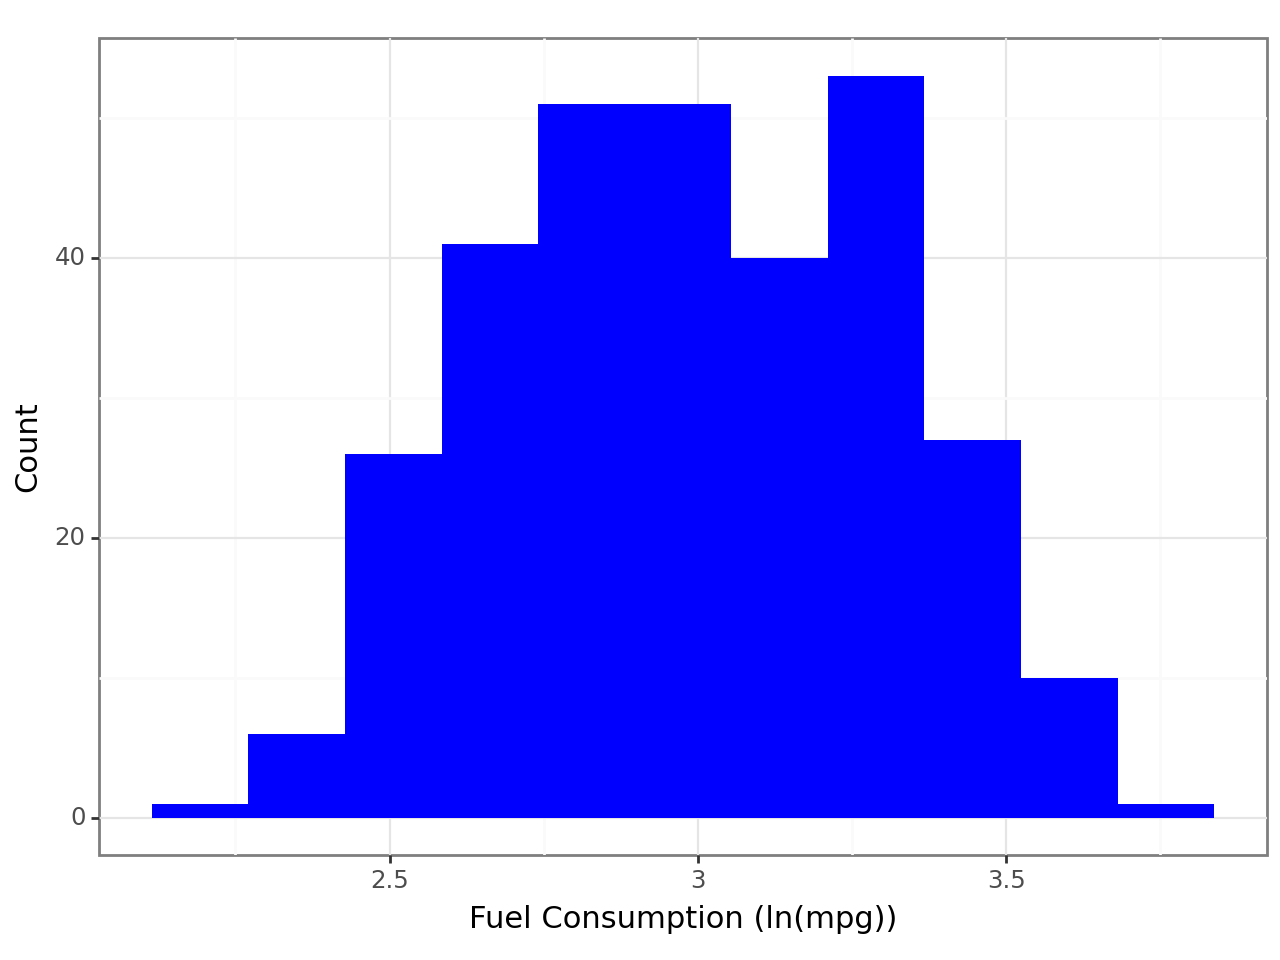

<Figure Size: (640 x 480)>

In [39]:
# Look at the distribution of lnmpg
(
    ggplot(data, aes(x = "lnmpg")) +
    geom_histogram(fill = "blue") +
    labs(x = "Fuel Consumption (ln(mpg))", y = "Count") +
    theme_bw()
)

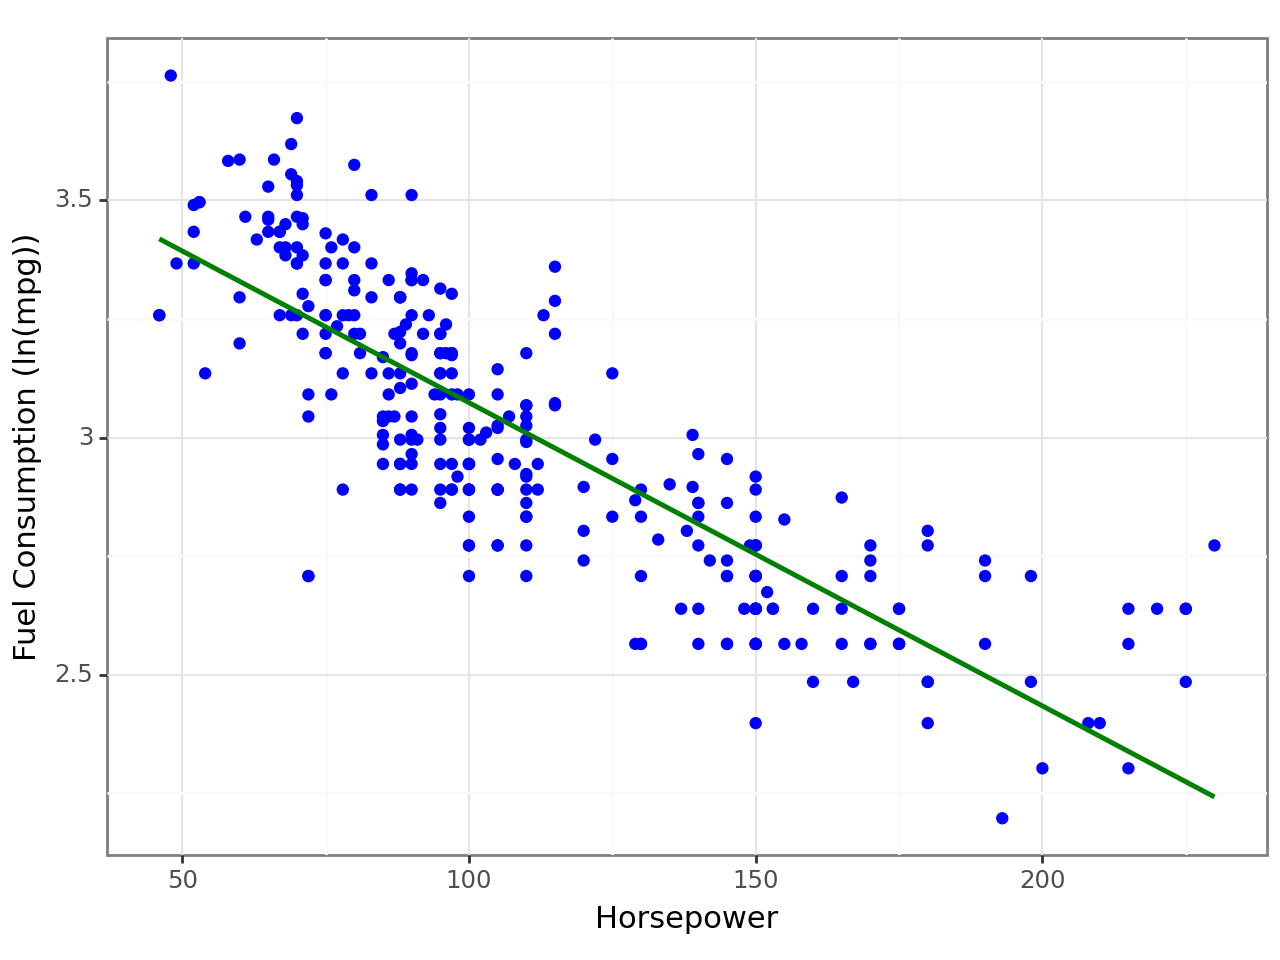

<Figure Size: (640 x 480)>

In [40]:
reg1 = smf.ols(formula="lnmpg~horsepower", data=data).fit()
(
    ggplot(data, aes(x = "horsepower", y = "lnmpg"))
    + geom_point(color = "blue")
    + geom_smooth(method="lm", color = "green", se=False)
    + labs(x = "Horsepower" , y = "Fuel Consumption (ln(mpg))")
    + theme_bw()
)

In [41]:
reg2 = smf.ols(formula="lnmpg~horsepower+displacement+weight", data=data).fit()

In [42]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnmpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     472.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          7.86e-114
Time:                        21:16:58   Log-Likelihood:                 193.98
No. Observations:                 307   AIC:                            -380.0
Df Residuals:                     303   BIC:                            -365.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9264      0.040     97.981      0.000       3.848       4.005
horsepower      -0.0016      0.000     -3.834      0.000      -0.002      -0.001
displacement    -0.0002      0.000     -1.087      0.278      -0.001       0.000
weight          -0.0002   2.33e-05     -9.559      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        2.357   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                2.280
Skew:                          -0.076   Prob(JB):                        0.320
Kurtosis:                       3.394   Cond. No.                     1.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

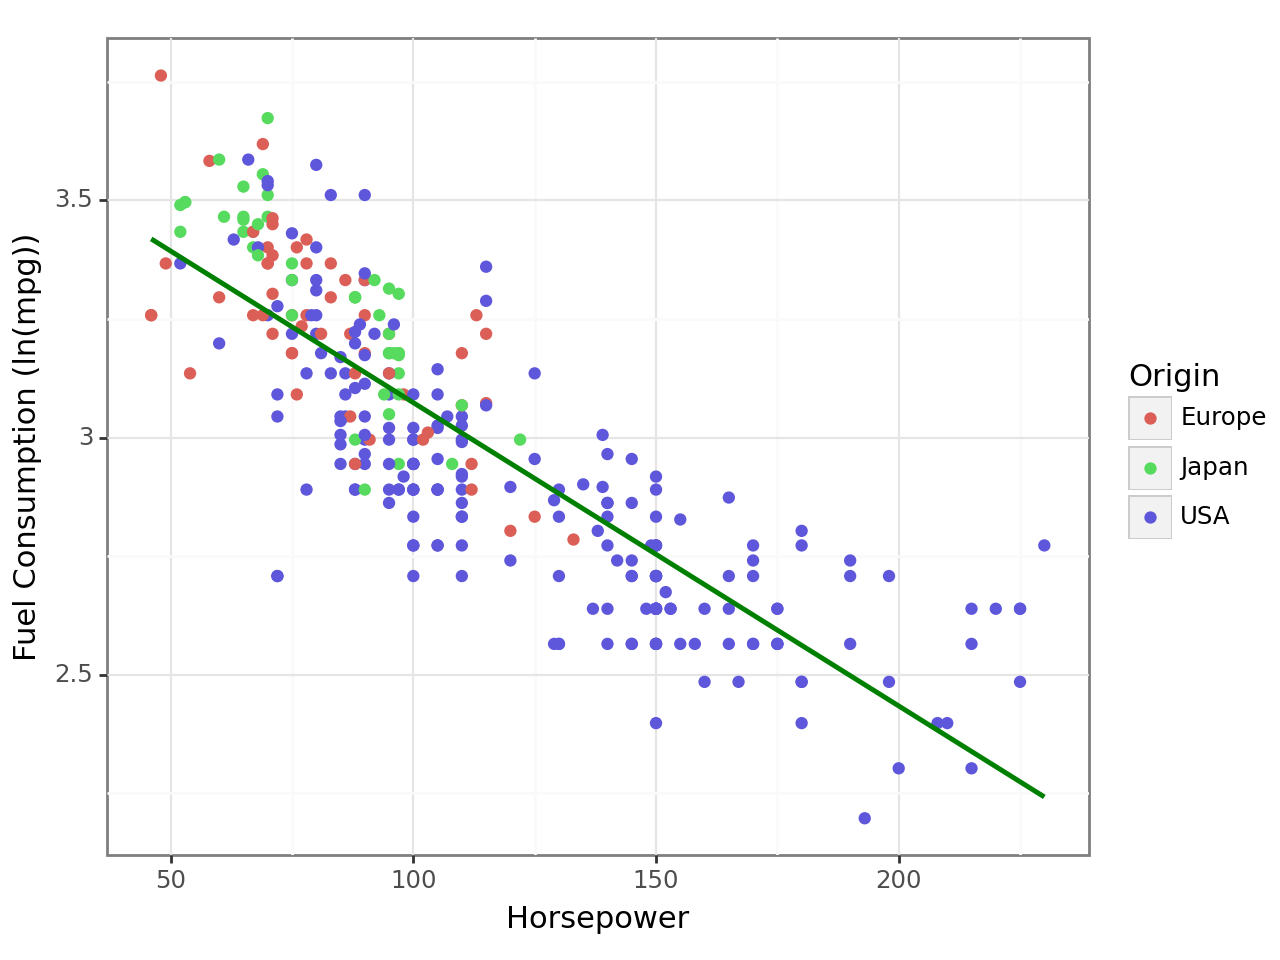

<Figure Size: (640 x 480)>

In [43]:
reg3 = smf.ols(formula="lnmpg~horsepower+IsEU+IsJP", data=data).fit()
(
    ggplot(data, aes(x = "horsepower", y = "lnmpg", color = "OriginName"))
    + geom_point()
    + geom_smooth(method="lm", color = "green", se=False)
    + labs(x = "Horsepower" , y = "Fuel Consumption (ln(mpg))", color = "Origin")
    + theme_bw()
)

In [48]:
stargazer = Stargazer([reg1,reg2,reg3])
stargazer.rename_covariates(
    {
        "Intercept" : "Constant",
        "horsepower" : "Horsepower",
        "displacement" : "Air Displacement",
        "weight" : "Car Weight (pounds)",
        "IsEU" : "Europe Origin",
        "IsJP" : "Japan Origin"
    }
)
stargazer.covariate_order(
    [
        "Intercept",
        "horsepower",
        "displacement",
        "weight",
        "IsEU",
        "IsJP"
    ]
)
stargazer